In [48]:
import numpy as np
import pandas as pd
import torch
import shutil 
from tqdm import tqdm
import os
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
from IPython.display import display, Image

In [3]:
data_root = '/kaggle/input/smoking-classification/smoking_classification'
print(os.listdir(data_root))

['train']


# Разделение датасета на валидационную и тренировочную выборки.

In [43]:
train_dir = 'train'
val_dir = 'val'
each_val_img_ind = 5 # каждое пятое изображение в валидацию

class_names = ['notsmoking', 'smoking']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % each_val_img_ind  != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 1038/1038 [00:02<00:00, 413.99it/s]


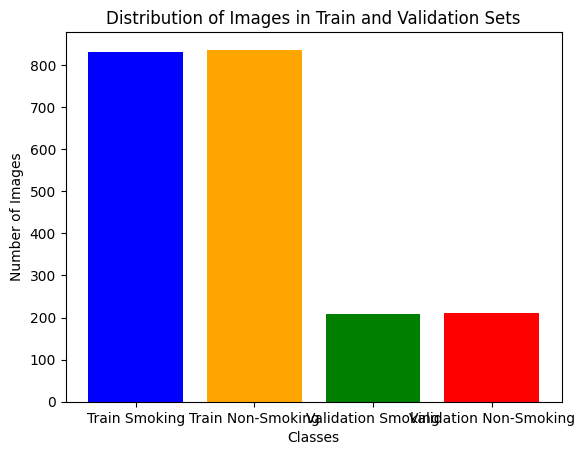

In [44]:
def print_data():
    train_smoking = len(os.listdir('/kaggle/working/train/smoking'))
    train_nonsmoking = len(os.listdir('/kaggle/working/train/notsmoking'))
    val_smoking = len(os.listdir('/kaggle/working/val/smoking'))
    val_nonsmoking = len(os.listdir('/kaggle/working/val/notsmoking'))
    labels = ['Train Smoking', 'Train Non-Smoking', 'Validation Smoking', 'Validation Non-Smoking']
    values = [train_smoking, train_nonsmoking, val_smoking, val_nonsmoking]
    plt.bar(labels, values, color=['blue', 'orange', 'green', 'red'])
    plt.title('Distribution of Images in Train and Validation Sets')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.show()
print_data()

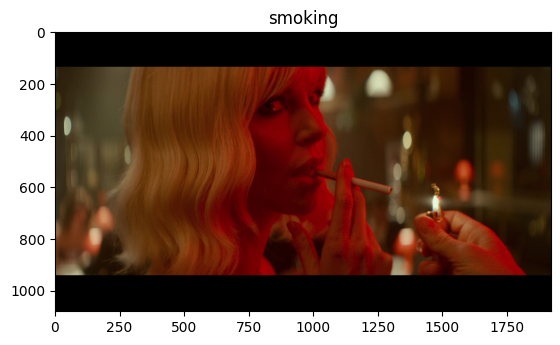

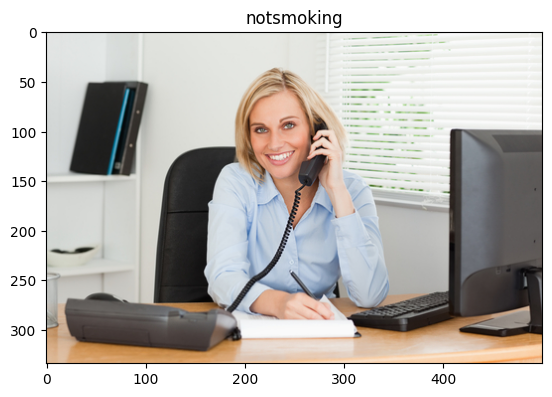

In [45]:
def show_random_image(image_folder):
    image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder)]
    random_image_path = random.choice(image_paths)
    folder_name = os.path.basename(os.path.dirname(random_image_path))
    image = Image.open(random_image_path)
    plt.imshow(image)
    plt.title(folder_name)
    plt.show()
    plt.pause(0.001)
show_random_image('/kaggle/working/train/smoking')
show_random_image('/kaggle/working/train/notsmoking')

# Предобработка датасета: применение аугментаций для датасета соревнования и open source.

In [46]:
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision.transforms.functional import adjust_brightness
image_folders_train = ["/kaggle/working/train/smoking", "/kaggle/working/train/notsmoking"]

# Аугментации к open source датасету
train_transforms_data_all = [
    transforms.Compose([
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),
        transforms.ToTensor(),
    ]),
    transforms.Compose([
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    transforms.Compose([
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
        transforms.RandomOrder([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
        ]),
        transforms.ToTensor(),
    ]),
    transforms.Compose([
        transforms.RandomRotation(60),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
        transforms.ToTensor(),
    ]),
    transforms.Compose([
        transforms.RandomGrayscale(p=1),
        transforms.RandomOrder([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
        ]),
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    transforms.Compose([
        transforms.RandomInvert(),
        transforms.ToTensor(),
]), 
     transforms.Compose([
        transforms.GaussianBlur(kernel_size=3),  # Применение гауссовского размытия
        transforms.ToTensor(),
    ]),
]
#Аугментации к датасету соревнования

# Определение функции для уменьшения яркости изображения
def reduce_brightness(image, factor):
    return adjust_brightness(image, factor)

train_transforms_dataset_source = [
    transforms.Compose([
        transforms.CenterCrop(1000),
        transforms.RandomGrayscale(p=1),
        transforms.ToTensor(),
    ]),
    transforms.Compose([
        transforms.CenterCrop(1000),
        transforms.Lambda(lambda x: reduce_brightness(x, 0.5)),  # Уменьшение яркости на 0.5
        transforms.ToTensor(),
    ]),
    transforms.Compose([
        transforms.CenterCrop(100),
        transforms.Lambda(lambda x: reduce_brightness(x, 0.3)),  # Уменьшение яркости на 0.3,
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
]

augment_number = 25

for image_folder in image_folders_train:
    for index_image, filename in enumerate(os.listdir(image_folder)):
        # Получение пути к текущему изображению
        image_path = os.path.join(image_folder, filename)

        if not filename.startswith('data_') and index_image % augment_number == 0:
            # Применение аугментаций
            for index, transform in enumerate(train_transforms_data_all):
                augmented_image = transform(Image.open(image_path))

                # Получение имени файла без расширения
                name, ext = os.path.splitext(filename)

                # Формирование имени аугментированного файла
                augmented_filename = f"{name}_{index}_augmented{ext}"

                # Сохранение аугментированного изображения
                output_path = os.path.join(image_folder, augmented_filename)
                save_image(augmented_image, output_path)
        elif filename.startswith('data_'):
            for index, transform in enumerate(train_transforms_dataset_source):
                augmented_image = transform(Image.open(image_path))

                name, ext = os.path.splitext(filename)

                augmented_filename = f"{name}_{index}_augmented{ext}"

                output_path = os.path.join(image_folder, augmented_filename)
                save_image(augmented_image, output_path)

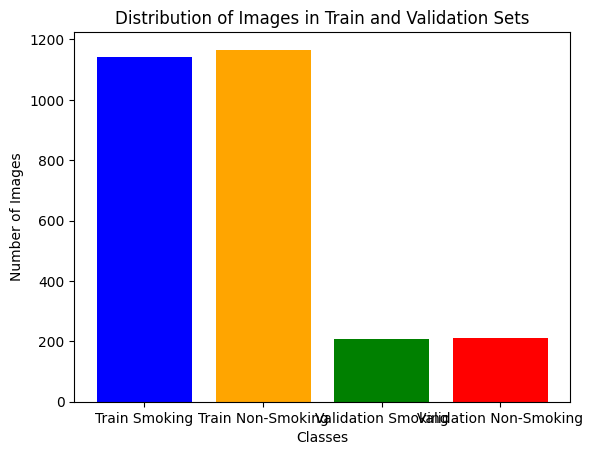

In [47]:
print_data()

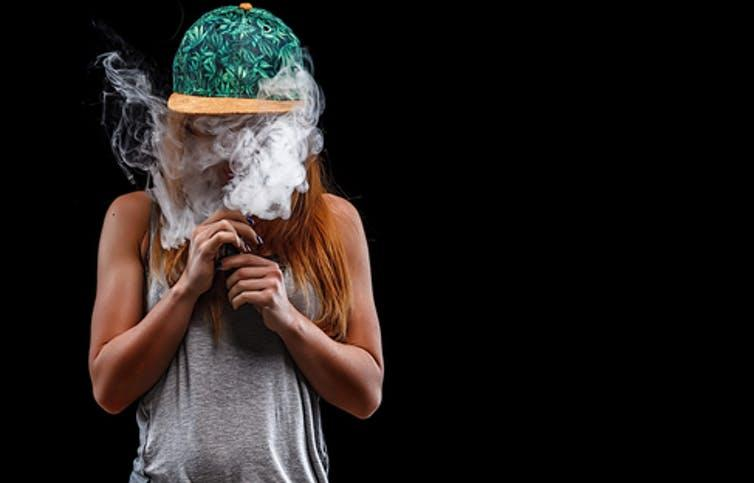

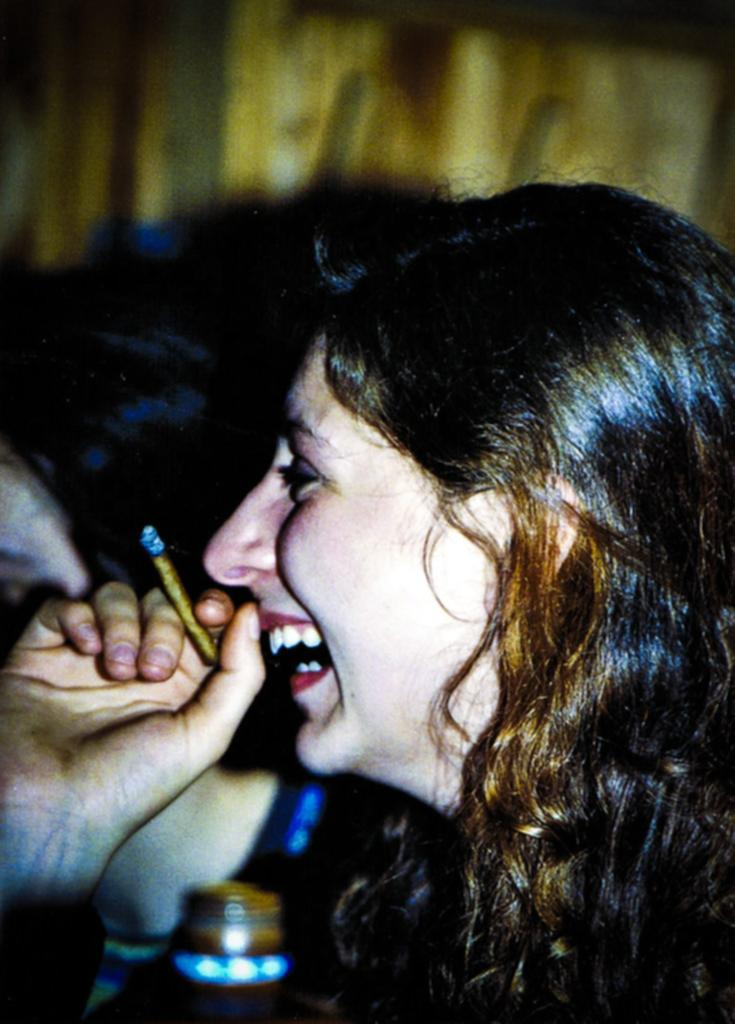

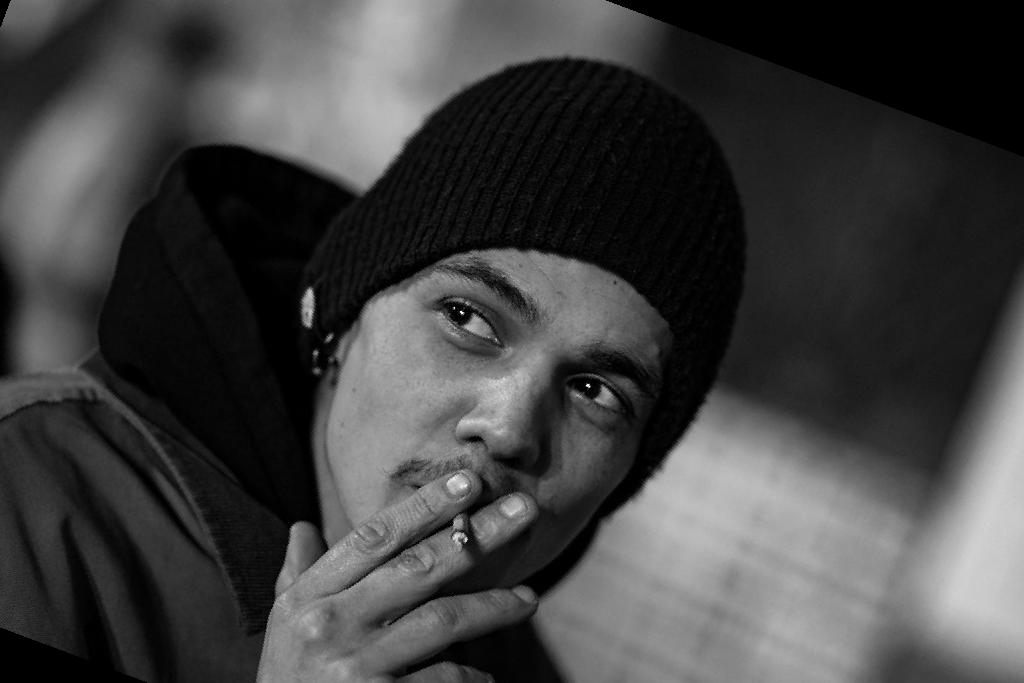

In [57]:
print_image = 3
total  = 0
image_folger = '/kaggle/working/train/smoking'
for filename in os.listdir(image_folger):
    if '_augmented' in filename:
        if total == print_image:
            break
        total+=1
        image_path = os.path.join(image_folger, filename)
        display(Image(filename=image_path, height=400))
        print("\n")

# Обучение нейросети.

In [63]:
!pip install ultralytics
import ultralytics
ultralytics.checks()
from ultralytics import YOLO

Ultralytics YOLOv8.2.2 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5608.0/8062.4 GB disk)


In [59]:
!nvidia-smi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Sat Apr 20 18:32:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [64]:
DATA_DIR='/kaggle/working/'
model = YOLO("yolov8l-cls.pt")
model.to(device)
results = model.train(data=f'{DATA_DIR}', epochs=20, imgsz=128)

100%|██████████| 32.7M/32.7M [00:00<00:00, 177MB/s] 


engine/trainer: task=classify, mode=train, model=yolov8m-cls.pt, data=/kaggle/working/, epochs=20, time=None, patience=100, batch=16, imgsz=128, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False,

2024-04-20 18:34:47,178	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-20 18:34:48,031	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-20 18:34:50.688037: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-20 18:34:50.688155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-20 18:34:50.848097: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLA

Overriding model.yaml nc=1000 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   2655744  ultralyti

100%|██████████| 6.23M/6.23M [00:00<00:00, 68.2MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/train... 2307 images, 1 corrupt: 100%|██████████| 2308/2308 [00:01<00:00, 2137.97it/s]

train: WARNING ⚠️ /kaggle/working/train/notsmoking/251.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/notsmoking/351.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/notsmoking/44.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/notsmoking/754.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/notsmoking/811.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/notsmoking/814.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/notsmoking/911.jpg: ignoring corrupt image/label: Invalid image format GIF. Supported formats are:
images: {'tif', 'mpo', 'bmp', 'jpg', 'pfm', 'dng', 'jpeg', 'png', 'webp', 'tiff'}
videos: {'ts', 'mpg', 'asf', 'avi', 'mp4', 'mov', 'mpeg', 'gif', 'm4v', 'wmv', 'mkv', 'webm'}
train: WARNING ⚠️ /kaggle/working/train/smoking/214.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /kaggle/working/train/smoki


val: Scanning /kaggle/working/val... 416 images, 2 corrupt: 100%|██████████| 418/418 [00:00<00:00, 2291.63it/s]

val: WARNING ⚠️ /kaggle/working/val/smoking/16.jpg: ignoring corrupt image/label: Invalid image format GIF. Supported formats are:
images: {'tif', 'mpo', 'bmp', 'jpg', 'pfm', 'dng', 'jpeg', 'png', 'webp', 'tiff'}
videos: {'ts', 'mpg', 'asf', 'avi', 'mp4', 'mov', 'mpeg', 'gif', 'm4v', 'wmv', 'mkv', 'webm'}
val: WARNING ⚠️ /kaggle/working/val/smoking/23.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/smoking/684.jpg: ignoring corrupt image/label: Invalid image format GIF. Supported formats are:
images: {'tif', 'mpo', 'bmp', 'jpg', 'pfm', 'dng', 'jpeg', 'png', 'webp', 'tiff'}
videos: {'ts', 'mpg', 'asf', 'avi', 'mp4', 'mov', 'mpeg', 'gif', 'm4v', 'wmv', 'mkv', 'webm'}


val: New cache created: /kaggle/working/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 38 weight(decay=0.0), 39 weight(decay=0.0005), 39 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 128 train, 128 val
Using 2 dataloader workers
Logging results to runs/classify/train
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/20     0.975G     0.7498         16        128:   5%|▍         | 7/145 [00:01<00:20,  6.75it/s]

       1/20     0.975G     0.7507         16        128:   7%|▋         | 10/145 [00:02<00:39,  3.44it/s]
100%|██████████| 755k/755k [00:00<00:00, 15.9MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]

                   all      0.863          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]

                   all      0.853          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]

                   all      0.897          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:04<00:00,  3.02it/s]

                   all      0.856          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]

                   all      0.875          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s]

                   all      0.875          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]

                   all      0.892          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s]

                   all       0.87          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]

                   all      0.863          1



      Epoch    GPU_mem       loss  Instances       Size


      10/20      1.01G      0.149          3        128: 100%|██████████| 145/145 [00:36<00:00,  3.98it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]

                   all      0.887          1



      Epoch    GPU_mem       loss  Instances       Size


      11/20      1.01G     0.1637          3        128: 100%|██████████| 145/145 [00:38<00:00,  3.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:06<00:00,  2.15it/s]

                   all      0.885          1



      Epoch    GPU_mem       loss  Instances       Size


      12/20      0.99G     0.1465          3        128: 100%|██████████| 145/145 [00:36<00:00,  3.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]

                   all      0.892          1



      Epoch    GPU_mem       loss  Instances       Size


      13/20      0.99G     0.1288          3        128: 100%|██████████| 145/145 [00:34<00:00,  4.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]

                   all      0.904          1



      Epoch    GPU_mem       loss  Instances       Size


      14/20      1.01G     0.1071          3        128: 100%|██████████| 145/145 [00:36<00:00,  3.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:04<00:00,  2.76it/s]

                   all      0.892          1



      Epoch    GPU_mem       loss  Instances       Size


      15/20      1.01G    0.09428          3        128: 100%|██████████| 145/145 [00:35<00:00,  4.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]

                   all      0.911          1



      Epoch    GPU_mem       loss  Instances       Size


      16/20      0.99G    0.07933          3        128: 100%|██████████| 145/145 [00:37<00:00,  3.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:04<00:00,  2.93it/s]

                   all      0.916          1



      Epoch    GPU_mem       loss  Instances       Size


      17/20      0.99G    0.06993          3        128: 100%|██████████| 145/145 [00:35<00:00,  4.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]

                   all      0.904          1



      Epoch    GPU_mem       loss  Instances       Size


      18/20      1.01G    0.08362          3        128: 100%|██████████| 145/145 [00:37<00:00,  3.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s]

                   all      0.904          1



      Epoch    GPU_mem       loss  Instances       Size


      19/20      1.01G    0.08243          3        128: 100%|██████████| 145/145 [00:33<00:00,  4.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:06<00:00,  2.13it/s]

                   all      0.899          1



      Epoch    GPU_mem       loss  Instances       Size


      20/20      0.99G     0.0706          3        128: 100%|██████████| 145/145 [00:37<00:00,  3.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s]

                   all      0.899          1



20 epochs completed in 0.239 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 31.7MB
Optimizer stripped from runs/classify/train/weights/best.pt, 31.7MB

Validating runs/classify/train/weights/best.pt...
Ultralytics YOLOv8.2.2 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-cls summary (fused): 103 layers, 15765218 parameters, 0 gradients, 41.6 GFLOPs
train: /kaggle/working/train... found 2308 images in 2 classes ✅ 
val: /kaggle/working/val... found 418 images in 2 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:04<00:00,  3.07it/s]


                   all      0.916          1
Speed: 0.0ms preprocess, 1.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train
Results saved to runs/classify/train


In [66]:
!yolo task=classify mode=val model=/kaggle/working/runs/classify/train/weights/best.pt data='{DATA_DIR}'

Ultralytics YOLOv8.2.2 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-cls summary (fused): 103 layers, 15765218 parameters, 0 gradients, 41.6 GFLOPs
train: /kaggle/working/train... found 2308 images in 2 classes ✅ 
val: /kaggle/working/val... found 418 images in 2 classes ✅ 
test: None...
val: Scanning /kaggle/working/val... 416 images, 2 corrupt: 100%|██████████| 416
val: WARNING ⚠️ /kaggle/working/val/smoking/16.jpg: ignoring corrupt image/label: Invalid image format GIF. Supported formats are:
images: {'tif', 'mpo', 'bmp', 'jpg', 'pfm', 'dng', 'jpeg', 'png', 'webp', 'tiff'}
videos: {'ts', 'mpg', 'asf', 'avi', 'mp4', 'mov', 'mpeg', 'gif', 'm4v', 'wmv', 'mkv', 'webm'}
val: WARNING ⚠️ /kaggle/working/val/smoking/23.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /kaggle/working/val/smoking/684.jpg: ignoring corrupt image/label: Invalid image format GIF. Supported formats are:
images: {'tif', 'mpo', 'bmp', 'jpg', 'pfm', 'dng', 'jpeg', 'png', 'webp', 'tiff'}
videos

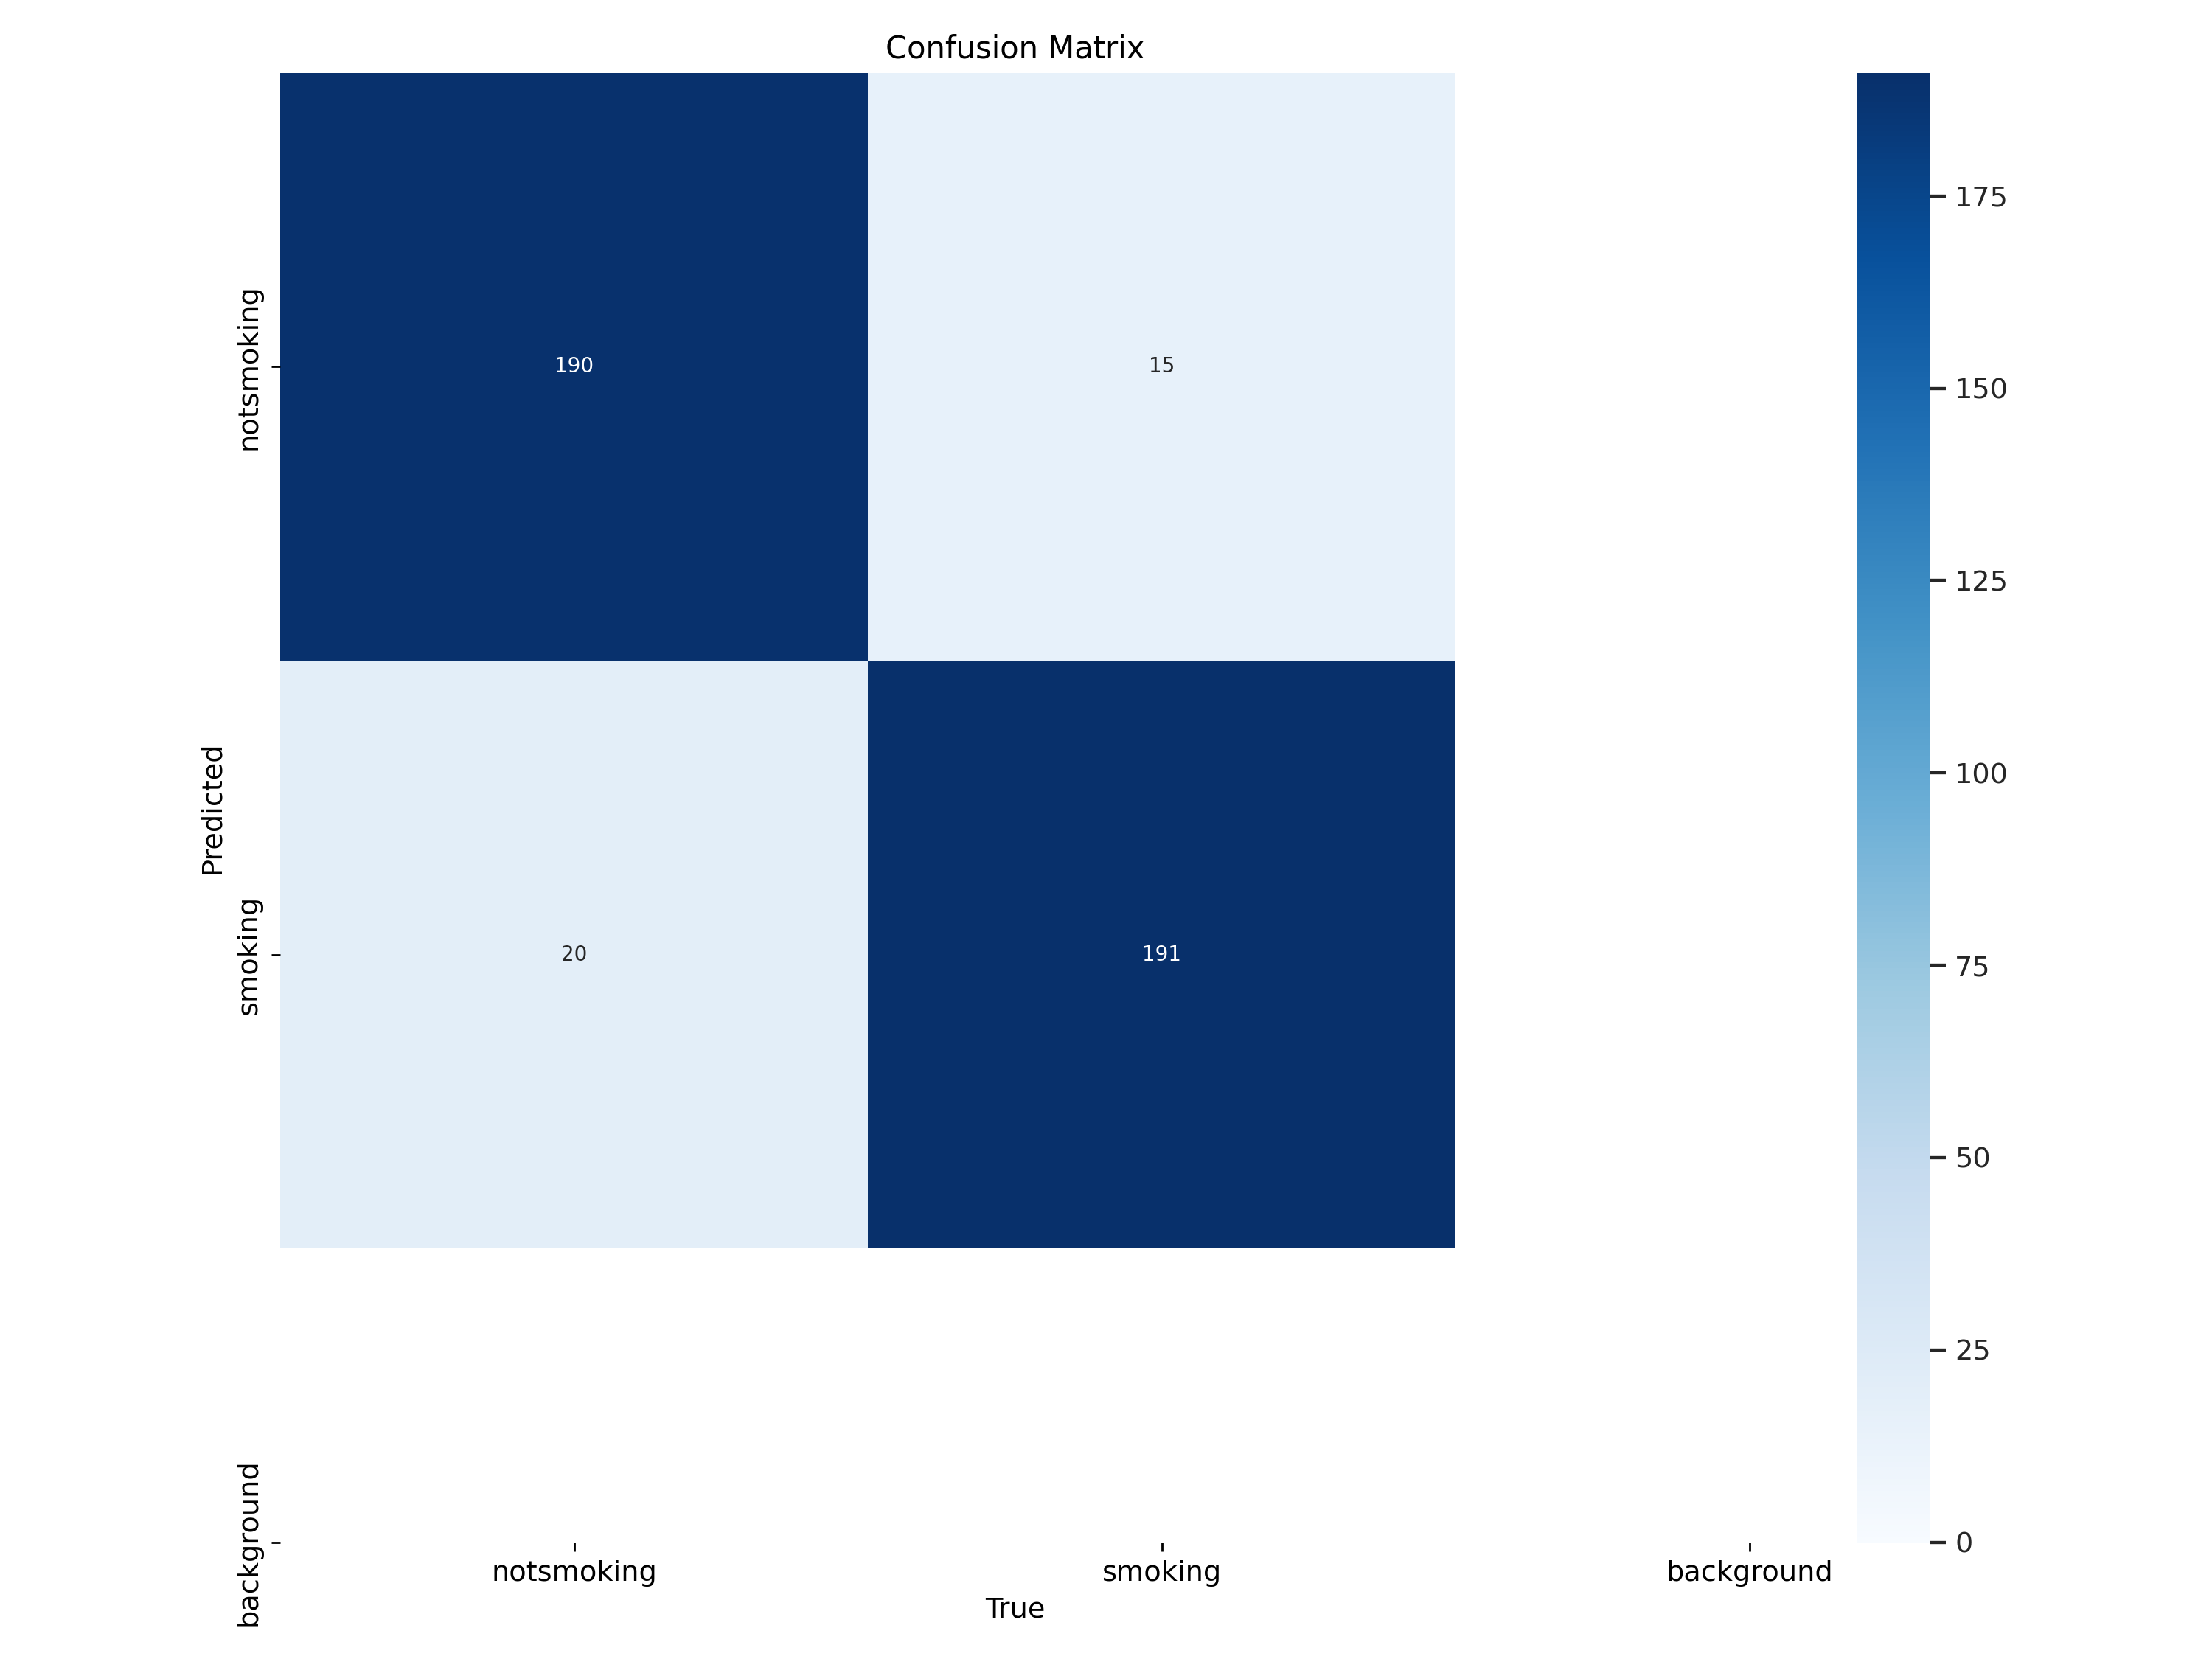

In [67]:
Image(filename=f'/kaggle/working/runs/classify/val/confusion_matrix.png')

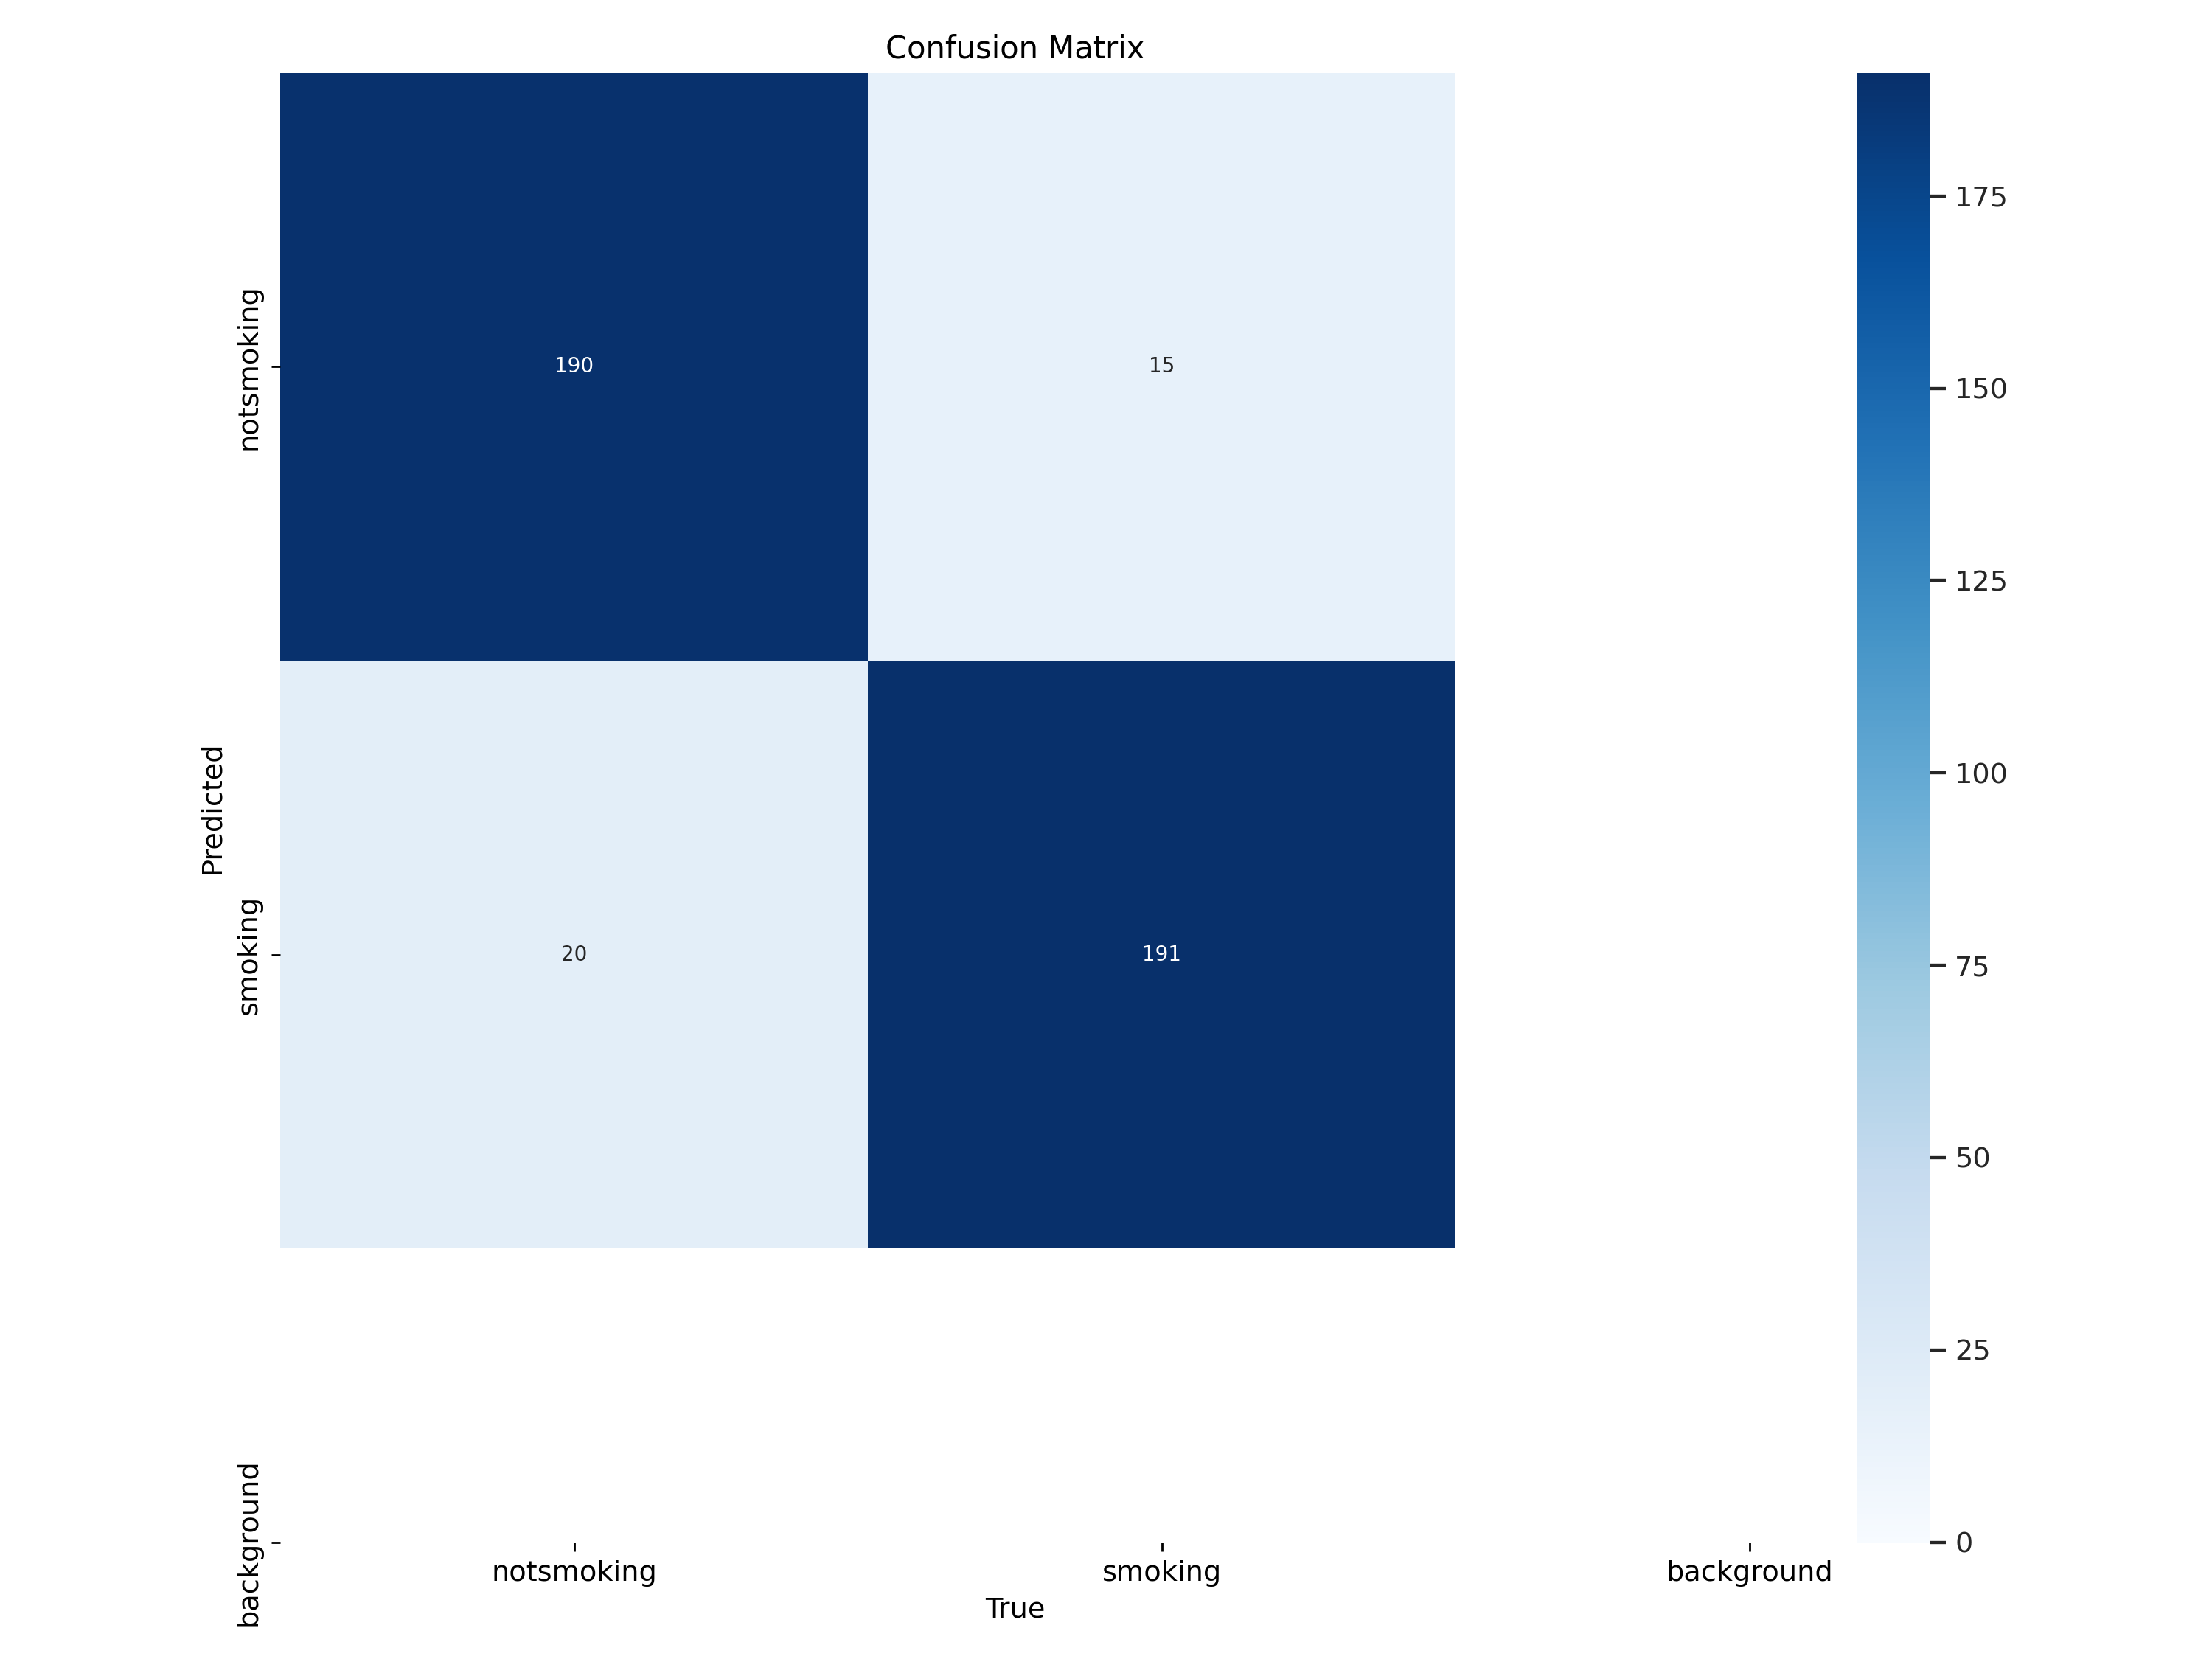

In [68]:
Image(filename=f'/kaggle/working/runs/classify/train/confusion_matrix.png')

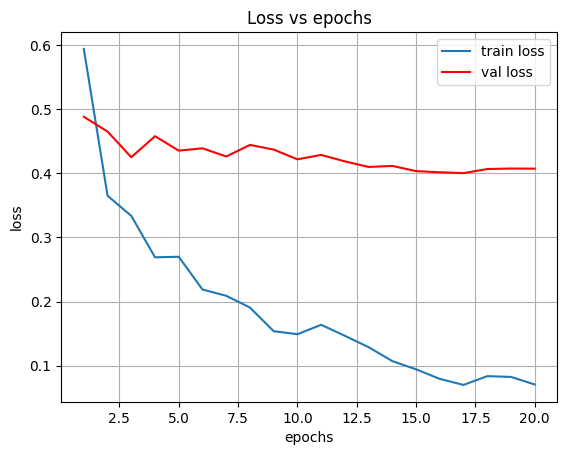

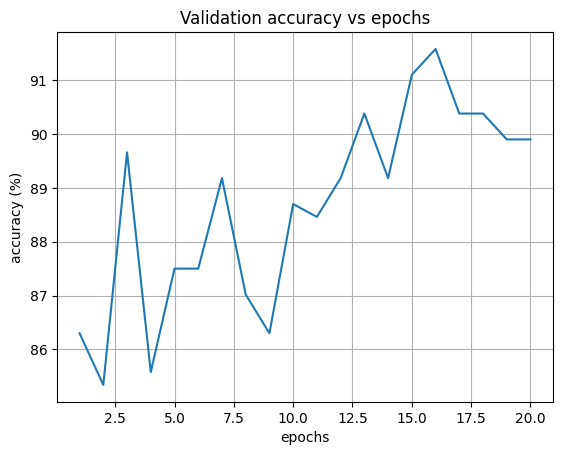

In [69]:
results_path = '/kaggle/working/runs/classify/train/results.csv'

results = pd.read_csv(results_path)

plt.figure()
plt.plot(results['                  epoch'], results['             train/loss'], label='train loss')
plt.plot(results['                  epoch'], results['               val/loss'], label='val loss', c='red')
plt.grid()
plt.title('Loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()


plt.figure()
plt.plot(results['                  epoch'], results['  metrics/accuracy_top1'] * 100)
plt.grid()
plt.title('Validation accuracy vs epochs')
plt.ylabel('accuracy (%)')
plt.xlabel('epochs')

plt.show()

# Получение предикта на тесте.

In [135]:
# вставьте папку с изображениями для теста : название/img1, img2...
# test = ''


In [136]:
!yolo task=classify mode=predict model=/kaggle/working/runs/classify/train/weights/best.pt conf=0.25 source={test}

Ultralytics YOLOv8.2.2 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-cls summary (fused): 103 layers, 15765218 parameters, 0 gradients, 41.6 GFLOPs

image 1/28 /kaggle/input/datadatat/новая/data_1006.jpg: 128x128 notsmoking 1.00, smoking 0.00, 5.8ms
image 2/28 /kaggle/input/datadatat/новая/data_1007.jpg: 128x128 notsmoking 1.00, smoking 0.00, 7.5ms
image 3/28 /kaggle/input/datadatat/новая/data_1008.jpg: 128x128 notsmoking 1.00, smoking 0.00, 5.9ms
image 4/28 /kaggle/input/datadatat/новая/data_1009.jpg: 128x128 notsmoking 1.00, smoking 0.00, 5.7ms
image 5/28 /kaggle/input/datadatat/новая/data_1010.jpg: 128x128 notsmoking 1.00, smoking 0.00, 6.3ms
image 6/28 /kaggle/input/datadatat/новая/data_1011.jpg: 128x128 notsmoking 1.00, smoking 0.00, 5.7ms
image 7/28 /kaggle/input/datadatat/новая/data_1012.jpg: 128x128 notsmoking 1.00, smoking 0.00, 5.8ms
image 8/28 /kaggle/input/datadatat/новая/data_1013.jpg: 128x128 notsmoking 1.00, smoking 0.00, 5.7ms
image 9/28 /kaggle/input

In [165]:
import glob

model = YOLO(f'/kaggle/working/runs/classify/train/weights/best.pt')
submissions = dict()  

file_list = os.listdir(test)
file_list.sort()

for image_path in file_list:
    filename = os.path.join(test, image_path)
    result = model( filename)
    probs = result[0].probs.data.tolist()
    name = result[0].names
    submissions[image_path] = max(zip(list(name.values()), probs), key=lambda x: x[1])[0]

submissionss = pd.Series(submissions)
submissionss.to_csv('submissions.csv')


image 1/1 /kaggle/input/datadatat/новая/data_1006.jpg: 128x128 notsmoking 1.00, smoking 0.00, 5.6ms
Speed: 15.1ms preprocess, 5.6ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

image 1/1 /kaggle/input/datadatat/новая/data_1007.jpg: 128x128 notsmoking 1.00, smoking 0.00, 5.5ms
Speed: 13.8ms preprocess, 5.5ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

image 1/1 /kaggle/input/datadatat/новая/data_1008.jpg: 128x128 notsmoking 1.00, smoking 0.00, 5.5ms
Speed: 13.9ms preprocess, 5.5ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

image 1/1 /kaggle/input/datadatat/новая/data_1009.jpg: 128x128 notsmoking 1.00, smoking 0.00, 5.4ms
Speed: 13.5ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

image 1/1 /kaggle/input/datadatat/новая/data_1010.jpg: 128x128 notsmoking 1.00, smoking 0.00, 5.6ms
Speed: 14.5ms preprocess, 5.6ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

image 1/1

In [183]:
for image_path in glob.glob(f'/kaggle/working/runs/classify/predict/*.jpg')[:3]:
    display(Image(filename=image_path, height=300))
    print("\n")

TypeError: 'module' object is not callable

# Детекция человека.

In [101]:
!pip install git+https://github.com/Deci-AI/super-gradients.git@stable

  Cloning https://github.com/Deci-AI/super-gradients.git (to revision stable) to /tmp/pip-req-build-kivc11cv
  Running command git clone --filter=blob:none --quiet https://github.com/Deci-AI/super-gradients.git /tmp/pip-req-build-kivc11cv
  Running command git checkout -q d7152a4d3b92f1be339f71493135627f9a3529c8
  Resolved https://github.com/Deci-AI/super-gradients.git to commit d7152a4d3b92f1be339f71493135627f9a3529c8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 4.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of albumentations to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [102]:
import pathlib
from super_gradients.training import models
from super_gradients.common.object_names import Models

[2024-04-20 19:20:56] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log
[WARNING]No module named 'pycocotools'


[2024-04-20 19:20:58] INFO - env_sanity_check.py - Library check is not supported when super_gradients installed through "git+https://github.com/..." command


In [166]:
model = models.get("yolo_nas_pose_l", pretrained_weights="coco_pose")
model.to(device)

[2024-04-20 20:35:21] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco_pose dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-04-20 20:35:21] INFO - checkpoint_utils.py - License Notification: YOLO-NAS-POSE pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS-POSE.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-04-20 20:35:22] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_pose_l


YoloNASPose_L(
  (backbone): NStageBackbone(
    (stem): YoloNASStem(
      (conv): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(48, eps=1e-06, momentum=0.03, affine=True, track_running_stats=True)
        )
        (branch_1x1): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2))
        (post_bn): BatchNorm2d(48, eps=1e-06, momentum=0.03, affine=True, track_running_stats=True)
        (rbr_reparam): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (stage1): YoloNASStage(
      (downsample): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=1e-06, momentum=0.03, affin

In [169]:

from PIL import Image

# Папка с изображениями для предсказания
folder_path = test

# Папка для сохранения предсказанных изображений
output_folder = '/kaggle/working/new'

# Создание папки для сохранения предсказанных изображений, если её ещё нет
os.makedirs(output_folder, exist_ok=True)

# Проход по каждому файлу в папке с изображениями для предсказания
for filename in os.listdir(folder_path):
    image_path = os.path.join(folder_path, filename)
    
    # Предобработка изображения
    image = Image.open(image_path)
    
    # Предсказание модели
    confidence = 0.6
    output = model.predict(image_path, conf=confidence)
    
    # Сохранение предсказанного изображения в папку output_folder
    output_path = os.path.join(output_folder, f"{filename}")
    output.save(output_path)


[2024-04-20 20:36:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-04-20 20:36:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-04-20 20:36:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-04-20 20:36:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-04-20 20:36:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-04-20 20:36:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-04-20 20:36:51] INFO -

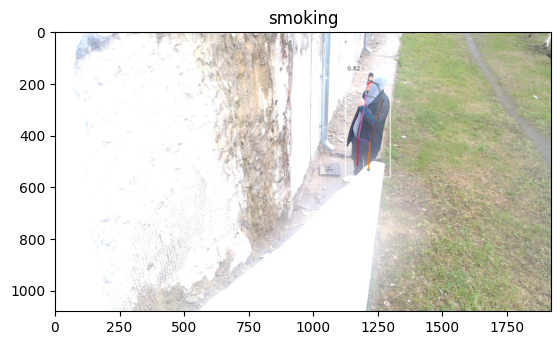

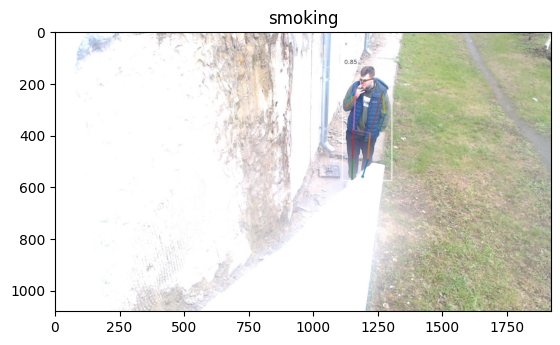

In [182]:
def show_random_image(image_folder, submissions):
    image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder)]
    random_image_path = random.choice(image_paths)
    image_name = random_image_path.split('new/')[1]
    image = Image.open(random_image_path)
    plt.imshow(image)
    plt.title(submissions[image_name])
    plt.show()
    plt.pause(0.001)

show_random_image('/kaggle/working/new', submissions)
show_random_image('/kaggle/working/new', submissions)

In [185]:
files = os.listdir('/kaggle/working')

# Удаляем каждый файл и директорию
for file in files:
    if os.path.isfile(file):
        os.remove(file)  # Удалить файл
    else:
        shutil.rmtree(file)  # Удалить директорию